In [140]:
### Read config file
import yaml

def read_config_file(config_file):
    with open(config_file, 'r') as stream:
        try:
            config = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return config

In [141]:
config_file = '/home/shiqi/code/Project2-sensor-case/model_combination_Argos/combined_model_20240805/outputs/experiment_1/config.yaml'
config = read_config_file(config_file)

In [142]:
import sys
sys.path.append('/home/shiqi/code/Project2-sensor-case/model_combination_Argos/utils')
from load_dataset import cut_slices, load_dataset
import numpy as np
import os

def data_preparation(config, data_dir):
    window_size = config['window_size']
    print(f'window_size: {window_size}')
    x_dataset, y_dataset, u_dataset = [], [], []
    # Load data
    for item in os.listdir(data_dir):
        data_file_path = os.path.join(data_dir, item)

        # Check if the file exists before trying to load it
        
        if os.path.exists(data_file_path) and data_file_path.endswith('.npy'):
            
            data_dict = np.load(data_file_path, allow_pickle=True).item()
            x_data, y_data, u_data, _ = load_dataset(data_dict)
            # print(x_data.shape, y_data.shape, u_data.shape)
            x_dataset.append(x_data[1:window_size])
            y_dataset.append(y_data[1:window_size])
            u_dataset.append(u_data[1:window_size])
            # print(f"Loaded data from {data_file_path}")
        else:
            print(f"File not found: {data_file_path}")

    print(x_dataset[0].shape, y_dataset[0].shape, u_dataset[0].shape)
    # Concatenate data
    x_data = np.concatenate(x_dataset, axis=0)
    y_data = np.concatenate(y_dataset, axis=0)
    u_data = np.concatenate(u_dataset, axis=0)
    print(f'x_data shape: {x_data.shape}, y_data shape: {y_data.shape}, u_data shape: {u_data.shape}')

    return x_data, y_data, u_data

In [143]:
import torch
import torch.nn as nn

class StdScalerLayer(nn.Module):
    def __init__(self, mean, std):
        super(StdScalerLayer, self).__init__()
        if not isinstance(mean, torch.Tensor):
            mean = torch.tensor(mean, dtype=torch.float32)
        if not isinstance(std, torch.Tensor):
            std = torch.tensor(std, dtype=torch.float32)
        self.mean = nn.Parameter(mean, requires_grad=False)
        self.std = nn.Parameter(std, requires_grad=False)

    def transform(self, x):
        return (x - self.mean) / self.std
    
    def inverse_transform(self, input):
        return input * self.std + self.mean
    
class Linear_model(torch.nn.Module):
    def __init__(self, state_dim, control_dim):
        super(Linear_model, self).__init__()
        self.A = torch.nn.Parameter(torch.randn(state_dim, state_dim))

        self.B = torch.nn.Parameter(torch.randn(control_dim, state_dim))
    
    def x_dict(self, x):
        ones = torch.ones(x.shape[0], 1).to(x.device)
        return torch.cat((x, ones), dim=1)
    
    def u_dict(self, u):
        return u
    
    def forward(self, x, u):
        x = self.x_dict(x)
        u = self.u_dict(u)
        y = torch.matmul(x, self.A) + torch.matmul(u, self.B)
        return y[:, 1:]
    
class PCALayer(nn.Module):
    def __init__(self, input_dim, output_dim, pca_matrix):
        super(PCALayer, self).__init__()
        self.pca_matrix = pca_matrix
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.transform = nn.Linear(input_dim, output_dim, bias = False)
        self.transform.weight = nn.Parameter(pca_matrix, requires_grad=False)
        self.inverse_transform = nn.Linear(output_dim, input_dim, bias = False)
        self.inverse_transform.weight = nn.Parameter(pca_matrix.T, requires_grad=False)


In [144]:
import torch
device = torch.device('cpu')
from sklearn.decomposition import PCA

# Load data
x_data, y_data, u_data = data_preparation(config, config['train_data_dir'])
x_data = torch.tensor(x_data, dtype=torch.float32).to(device)
y_data = torch.tensor(y_data, dtype=torch.float32).to(device)
u_data = torch.tensor(u_data, dtype=torch.float32).to(device)

x_dim = x_data.shape[-1]
u_dim = u_data.shape[-1]

## PCA
# Standardize data
mean_1 = torch.mean(x_data, dim=0)
std_1 = torch.std(x_data, dim=0)
std_layer_1 = StdScalerLayer(mean_1, std_1)
x_data_scaled = std_layer_1.transform(x_data)

# PCA layer
pca = PCA(n_components=config['pca_dim'])
# Ensure x_data_scaled is converted back to a NumPy array for PCA
pca.fit(x_data_scaled.detach().cpu().numpy())
components = pca.components_
pca_matrix = torch.tensor(components, dtype=torch.float32).to(device)
print(f'PCA matrix shape: {pca_matrix.shape}')
pca_layer = PCALayer(x_dim, config['pca_dim'], pca_matrix)

# Standardize data 2
x_pca = pca_layer.transform(x_data_scaled)
mean_2 = torch.mean(x_pca, dim=0)
std_2 = torch.std(x_pca, dim=0)
std_layer_2 = StdScalerLayer(mean_2, std_2)

# Build pca dataset
x_pca_scaled = std_layer_2.transform(x_pca)
y_data_scaled = std_layer_1.transform(y_data)
y_pca = pca_layer.transform(y_data_scaled)
y_pca_scaled = std_layer_2.transform(y_pca)
mean_u = torch.mean(u_data, dim=0)
std_u = torch.std(u_data, dim=0)
std_layer_u = StdScalerLayer(mean_u, std_u)
u_data_scaled = std_layer_u.transform(u_data)
dataset = [x_pca_scaled, y_pca_scaled, u_data_scaled]
print(f'PCA data shape: {x_pca_scaled.shape}, {y_pca_scaled.shape}, {u_data_scaled.shape}')


window_size: 150
(149, 6957) (149, 6957) (149, 2)
x_data shape: (6258, 6957), y_data shape: (6258, 6957), u_data shape: (6258, 2)
PCA matrix shape: torch.Size([4, 6957])
PCA data shape: torch.Size([6258, 4]), torch.Size([6258, 4]), torch.Size([6258, 2])


In [145]:
import torch

def Build_Hankel_Matrix(y, i, j):
    """
    Construct the Hankel matrix H_y from y(t).
    """
    y_dim = y.shape[0]
    T = y.shape[1]
    H_y = torch.zeros(2*i*y_dim, j)
    if 2 * i + j > T:
        raise ValueError("The given i and j are too large for the given data.")
    for k in range(2 * i):
        H_y[k*y_dim:(k+1)*y_dim, :] = y[:, k:k+j]
    return H_y

def H_past_Matrix(H_y, i, y_dim):
    """
    Construct the past matrix H_{y,past} from the Hankel matrix H_y.
    """
    return H_y[:i*y_dim, :]

def H_future_Matrix(H_y, i, y_dim):
    """
    Construct the future matrix H_{y,future} from the Hankel matrix H_y.
    """
    return H_y[i*y_dim:2*i*y_dim, :]

def H_past_Matrix_plus(H_y, i, y_dim):
    """
    Construct the past matrix H_{y,past}^+ from the Hankel matrix H_y.
    """
    return H_y[:(i+1)*y_dim, :]

def H_future_Matrix_minus(H_y, i, y_dim):
    """
    Construct the future matrix H_{y,future}^- from the Hankel matrix H_y.
    """
    return H_y[(i+1)*y_dim:(2*i+1)*y_dim, :]

In [146]:
import torch

def truncated_svd_pinv(matrix, threshold=1e-2):
    """
    Compute the pseudoinverse of a matrix using truncated SVD to improve numerical stability.
    """
    U, S, V = torch.svd(matrix)
    
    # 只保留大于阈值的奇异值及其对应的U和V
    valid_indices = S > threshold
    S_truncated = S[valid_indices]
    U_truncated = U[:, valid_indices]
    V_truncated = V[:, valid_indices]
    
    # 计算截断后的S_inv
    S_inv = torch.diag(1.0 / S_truncated)
    
    # 计算伪逆矩阵
    return V_truncated @ S_inv @ U_truncated.T

# Define the Orthogonal and Oblique Projections
def Orthogonal_Complement(A):
    """
    Compute the orthogonal complement of matrix A.
    """
    print("Condition number of A @ A.T (regularized):", torch.linalg.cond(A @ A.T + 1e-2 * torch.eye(A.shape[0])))
    # print("A @ A.T:", A @ A.T)
    return torch.eye(A.shape[1]) - A.T @ truncated_svd_pinv(A @ A.T) @ A

def Orthogonal_Projection(A, B):
    """
    Compute the orthogonal projection of the row vectors of matrix A onto the row vectors of matrix B.
    """
    print("Condition number of B @ B.T:", torch.linalg.cond(B @ B.T))
    return A @ B.T @ truncated_svd_pinv(B @ B.T) @ B

def Oblique_Projection(A, B, C):
    """
    Calculate the oblique projection of matrix A onto the subspace spanned by the row vectors of matrix C with the direction of matrix B.
    """
    B_orth = Orthogonal_Complement(B)
    P_ABorth = Orthogonal_Projection(A, B_orth)
    P_CBorth = Orthogonal_Projection(C, B_orth)
    print("Condition number of P_CBorth:", torch.linalg.cond(P_CBorth))
    return P_ABorth @ truncated_svd_pinv(P_CBorth) @ C

In [147]:
def Subspace_Identification(y, u, i, j):
    H_y = Build_Hankel_Matrix(y, i, j)
    H_u = Build_Hankel_Matrix(u, i, j)
    Y_p = H_past_Matrix(H_y, i, y.shape[0])
    Y_f = H_future_Matrix(H_y, i, y.shape[0])
    U_p = H_past_Matrix(H_u, i, u.shape[0])
    U_f = H_future_Matrix(H_u, i, u.shape[0])
    Y_p_plus = H_past_Matrix_plus(H_y, i, y.shape[0])
    Y_f_minus = H_future_Matrix_minus(H_y, i, y.shape[0])
    U_p_plus = H_past_Matrix_plus(H_u, i, u.shape[0])
    U_f_minus = H_future_Matrix_minus(H_u, i, u.shape[0])
    W_p = torch.cat((Y_p, U_p), 0)
    W_p_plus = torch.cat((Y_p_plus, U_p_plus), 0)

    # Calculate the oblique projection
    O_i = Oblique_Projection(Y_f, U_f, W_p)
    O_i_minus = Oblique_Projection(Y_f_minus, U_f_minus, W_p_plus)

    # Calculate the SVD of the weighted oblique projection
    U, S, VT = torch.svd(O_i)
    print(O_i.shape)

    # Determine the order of the system
    threshold = 1e-3
    r = torch.sum(S > threshold).item()
    U_1 = U[:, :r]
    S_1 = torch.diag(S[:r])
    print(S)

    # Determine Gamma_i and Gamma_{i-1}
    Gamma_i = U_1 @ torch.sqrt(S_1)
    print(Gamma_i.shape)
    Gamma_i_minus = Gamma_i[y.shape[0]:, :]

    # Determine X_i and X_{i+1}
    X_i = torch.linalg.pinv(Gamma_i) @ O_i
    X_i_plus = torch.linalg.pinv(Gamma_i_minus) @ O_i_minus

    # Determine the system matrices
    Y_i = H_y[i*y.shape[0]:(i+1)*y.shape[0], :]
    U_i = H_u[i*u.shape[0]:(i+1)*u.shape[0], :]

    X_plus_Y = torch.cat((X_i_plus, Y_i), 0)
    X_U = torch.cat((X_i, U_i), 0)

    System_Matrices = X_plus_Y @ torch.linalg.pinv(X_U)
    A = System_Matrices[:X_i.shape[0], :X_i.shape[0]]
    B = System_Matrices[:X_i.shape[0], X_i.shape[0]:]
    C = System_Matrices[X_i.shape[0]:, :X_i.shape[0]]
    D = System_Matrices[X_i.shape[0]:, X_i.shape[0]:]

    return A, B, C, D


In [164]:
xx = x_pca_scaled[:config['window_size']-1, :].T
uu = u_data_scaled[:config['window_size']-1, :].T
A_pred, B_pred, C_pred, D_pred = Subspace_Identification(xx, uu, 20, 5)

Condition number of A @ A.T (regularized): tensor(6566.5649)
Condition number of B @ B.T: tensor(2.0550e+08)
Condition number of B @ B.T: tensor(2.0550e+08)
Condition number of P_CBorth: tensor(62655796.)
Condition number of A @ A.T (regularized): tensor(6220.4907)
Condition number of B @ B.T: tensor(1.3532e+08)
Condition number of B @ B.T: tensor(1.3532e+08)
Condition number of P_CBorth: tensor(48170588.)
torch.Size([80, 5])
tensor([5.3083e+00, 2.3738e+00, 3.6527e-01, 8.1739e-07, 5.6308e-07])
torch.Size([80, 3])


In [165]:
print(A_pred, B_pred, C_pred, D_pred)

tensor([[ 9.8913e-01,  2.1768e-03, -8.5658e-04],
        [-1.4739e-02,  1.0030e+00, -9.4818e-04],
        [ 1.5938e-02, -3.4100e-03,  1.0011e+00]]) tensor([[ 0.7189, -0.6657],
        [ 0.6622, -0.6403],
        [-3.7564,  3.2421]]) tensor([[-3.7098e-03, -1.7213e-02,  1.3246e-04],
        [-6.1497e-02,  4.5542e-02, -7.1792e-03],
        [-1.9303e-01,  5.4495e-01, -9.5417e-02],
        [-8.4990e-01, -2.0730e-01, -1.8458e-01]]) tensor([[ -7.3426,   6.4661],
        [ -7.0356,   8.3968],
        [ 11.5485, -10.5638],
        [  4.4958,  -3.2374]])


In [166]:
C_pred.shape

torch.Size([4, 3])

In [167]:
def generate_linear_trajectories(y_dataset, u_dataset, matrices, std_layer_1, pca_transformer, std_layer_2, std_layer_u, divice = 'cpu'):
    A, B, C, D = matrices
    x_dim = A.shape[0]
    u_dim = B.shape[0]
    y_data_pca_pred_traj = []
    y_data_pca_traj = []
    y_data_pred_traj = []
    for y_data, u_data in zip(y_dataset, u_dataset):
        y_data = torch.tensor(y_data, dtype=torch.float32).to(device)
        u_data = torch.tensor(u_data, dtype=torch.float32).to(device)
        y_data_scaled = std_layer_1.transform(y_data)
        y_pca = pca_transformer.transform(y_data_scaled)
        y_pca_scaled = std_layer_2.transform(y_pca)
        y_pred = torch.zeros(y_pca_scaled.shape)
        y_pred[0, :] = y_pca_scaled[0, :]

        u_data_scaled = std_layer_u.transform(u_data)
        y0 = y_pca_scaled[0, :].unsqueeze(0)
        x0 = torch.linalg.pinv(C) @ (y0.T - D @ u_data_scaled[0, :].unsqueeze(0).T)
        # print(x0.shape)
        for i in range(1, y_data_scaled.shape[0]):
            x1 = A @ x0 + B @ u_data_scaled[i-1, :].unsqueeze(0).T
            y1 = C @ x1 + D @ u_data_scaled[i-1, :].unsqueeze(0).T
            x0 = x1
            y_pred[i, :] = y1.T
        y_data_pca_traj.append(y_pca_scaled.detach().cpu().numpy())
        y_data_pca_pred_traj.append(y_pred.detach().cpu().numpy())
        y_pca_pred = std_layer_2.inverse_transform(y_pred)
        y_data_pred_scaled = pca_transformer.inverse_transform(y_pca_pred)
        y_data_pred = std_layer_1.inverse_transform(y_data_pred_scaled)
        y_data_pred_traj.append(y_data_pred.detach().cpu().numpy())
    
    return y_data_pred_traj, y_data_pca_pred_traj, y_data_pca_traj

            

In [168]:
# Evaluation data
### Evaluation
def load_evaluation_data(begin, end, data_dir):
    x_dataset = []
    u_dataset = []

    for item in os.listdir(data_dir):
        data_file_path = os.path.join(data_dir, item)

        # Check if the file exists before trying to load it
        if os.path.exists(data_file_path) and item.endswith('.npy'):
            data_dict = np.load(data_file_path, allow_pickle=True).item()
            x_data, _, u_data, _ = load_dataset(data_dict)
            x_dataset.append(x_data[begin:end, :])
            u_dataset.append(u_data[begin:end, :])
        else:
            print(f"File not found: {data_file_path}")
    
    return x_dataset, u_dataset

print(config['begin'], config['end'], config['train_data_dir'])
x_dataset_train, u_dataset_train = load_evaluation_data(config['begin'], config['end'], config['train_data_dir'])
x_dataset_test, u_dataset_test = load_evaluation_data(config['begin'], config['end'], config['test_data_dir'])


1 151 /home/shiqi/code/Project2-sensor-case/model_combination_Argos/data_dir/data_20240621


In [169]:
matrices = [A_pred, B_pred, C_pred, D_pred]
x_data_pred_traj_train, x_data_pca_traj_train, x_data_pca_pred_traj_train = generate_linear_trajectories(y_dataset=x_dataset_train, u_dataset=u_dataset_train, matrices=matrices, std_layer_1=std_layer_1, pca_transformer=pca_layer, std_layer_2=std_layer_2, std_layer_u=std_layer_u)
x_data_pred_traj_test, x_data_pca_traj_test, x_data_pca_pred_traj_test = generate_linear_trajectories(y_dataset=x_dataset_test, u_dataset=u_dataset_test, matrices=matrices, std_layer_1=std_layer_1, pca_transformer=pca_layer, std_layer_2=std_layer_2, std_layer_u=std_layer_u)

In [170]:
def calculate_relative_diff(x_true, x_pred):
    row_norm_diff = np.linalg.norm(x_true - x_pred, axis=1, ord=2)
    max_norm = np.max(np.linalg.norm(x_true, axis=1, ord=2))
    relative_diff = row_norm_diff / max_norm
    return relative_diff

def calculate_mean_relative_diff_set(x_true_traj, x_pred_traj):
    relative_diffs = [calculate_relative_diff(x_true, x_pred) for x_true, x_pred in zip(x_true_traj, x_pred_traj)]
    mean_relative_diffs = np.mean(relative_diffs, axis=0)
    return mean_relative_diffs

def calculate_relative_error(x_true, x_pred):
    row_norm_diff = np.linalg.norm(x_true - x_pred, ord='fro')
    total_norm_true = np.linalg.norm(x_true, ord='fro')
    return row_norm_diff / total_norm_true

def calculate_mean_relative_error_set(x_true_traj, x_pred_traj):
    relative_errors = [calculate_relative_error(x_true, x_pred) for x_true, x_pred in zip(x_true_traj, x_pred_traj)]
    return relative_errors

In [171]:
# Calculate mean relative error
mean_relative_errors_train = calculate_mean_relative_error_set(x_dataset_train, x_data_pred_traj_train)
mean_relative_errors_test = calculate_mean_relative_error_set(x_dataset_test, x_data_pred_traj_test)

# Calculate mean relative diff
mean_relative_diffs_train = calculate_mean_relative_diff_set(x_dataset_train, x_data_pred_traj_train)
mean_relative_diffs_test = calculate_mean_relative_diff_set(x_dataset_test, x_data_pred_traj_test)


In [172]:
print(f'Mean relative error for training set: {mean_relative_errors_train}')

Mean relative error for training set: [0.6357471274967845, 0.6839722614055913, 0.8173852156824154, 0.7495198651801868, 0.8589355351409917, 0.49964244902925076, 0.5155532001511233, 0.8751047561584253, 0.6509929999657866, 0.7045962347970769, 0.6252448737022919, 0.6078906925272624, 0.5067794343565473, 0.617128283409348, 0.6027814461309743, 0.7062788011716703, 0.9075346851678265, 0.5661425764503499, 0.7033964845115916, 0.584697905174438, 0.7957787082520555, 0.7085215188848377, 0.5601993024612083, 0.910976163314961, 0.8560867475414038, 0.5458952543256083, 0.6721905795807741, 0.7352004750803292, 0.8861513031028463, 0.6100058305081956, 0.9260687287156034, 0.8007999257097911, 0.6177866149995155, 0.8453052973018669, 0.6751502326007168, 0.9023836760279682, 0.9139572517110433, 0.6946636497449866, 0.6699206491250488, 0.9197222810595823, 0.7729840133334218, 0.8229484940935187]


In [173]:
print(f'Mean relative error for test set: {mean_relative_errors_test}')

Mean relative error for test set: [0.683389672827735, 0.6578956657791003, 0.8212825411654621, 0.6166986239044234, 0.5284657097935355, 0.6829716071656263, 0.6590719109751917, 0.6099897419827908, 0.9120481452134538, 0.6311118002968565]


In [174]:
print(f'Mean relative error for test set: {mean_relative_diffs_train}')

Mean relative error for test set: [0.00905585 0.51327617 0.43273917 0.34824966 0.27049244 0.2107788
 0.18218773 0.18570486 0.20771109 0.23427222 0.2572205  0.27288374
 0.2804581  0.28129361 0.27857473 0.27702617 0.28160528 0.29468115
 0.31617595 0.34443677 0.37647415 0.40808349 0.43364078 0.44801126
 0.45029329 0.44457644 0.43730272 0.43381013 0.43710432 0.44785398
 0.46481165 0.48549707 0.50718304 0.52738361 0.54409597 0.55605626
 0.56285117 0.5649279  0.56349099 0.56047974 0.55816136 0.55856105
 0.56273608 0.56981667 0.57687909 0.58084433 0.57978855 0.57286112
 0.55969389 0.54023593 0.51734738 0.49416679 0.47253855 0.45328214
 0.43584697 0.41998465 0.4058745  0.39347069 0.38270682 0.37313605
 0.36446773 0.35698432 0.3512728  0.34775274 0.34636781 0.34677243
 0.34889918 0.35280229 0.3589574  0.36805255 0.38061119 0.39679205
 0.41638534 0.43824285 0.46029595 0.48071594 0.49858592 0.51381064
 0.52698913 0.53829889 0.54735274 0.55421017 0.56005359 0.56614469
 0.57250809 0.57864305 0.5843

In [175]:
np.save('subspace_mean_relative_errors_train.npy', mean_relative_errors_train)
np.save('subspace_mean_relative_errors_test.npy', mean_relative_errors_test)
np.save('subspace_mean_relative_diffs_train.npy', mean_relative_diffs_train)
np.save('subspace_mean_relative_diffs_test.npy', mean_relative_diffs_test)


[16 27]
0
1


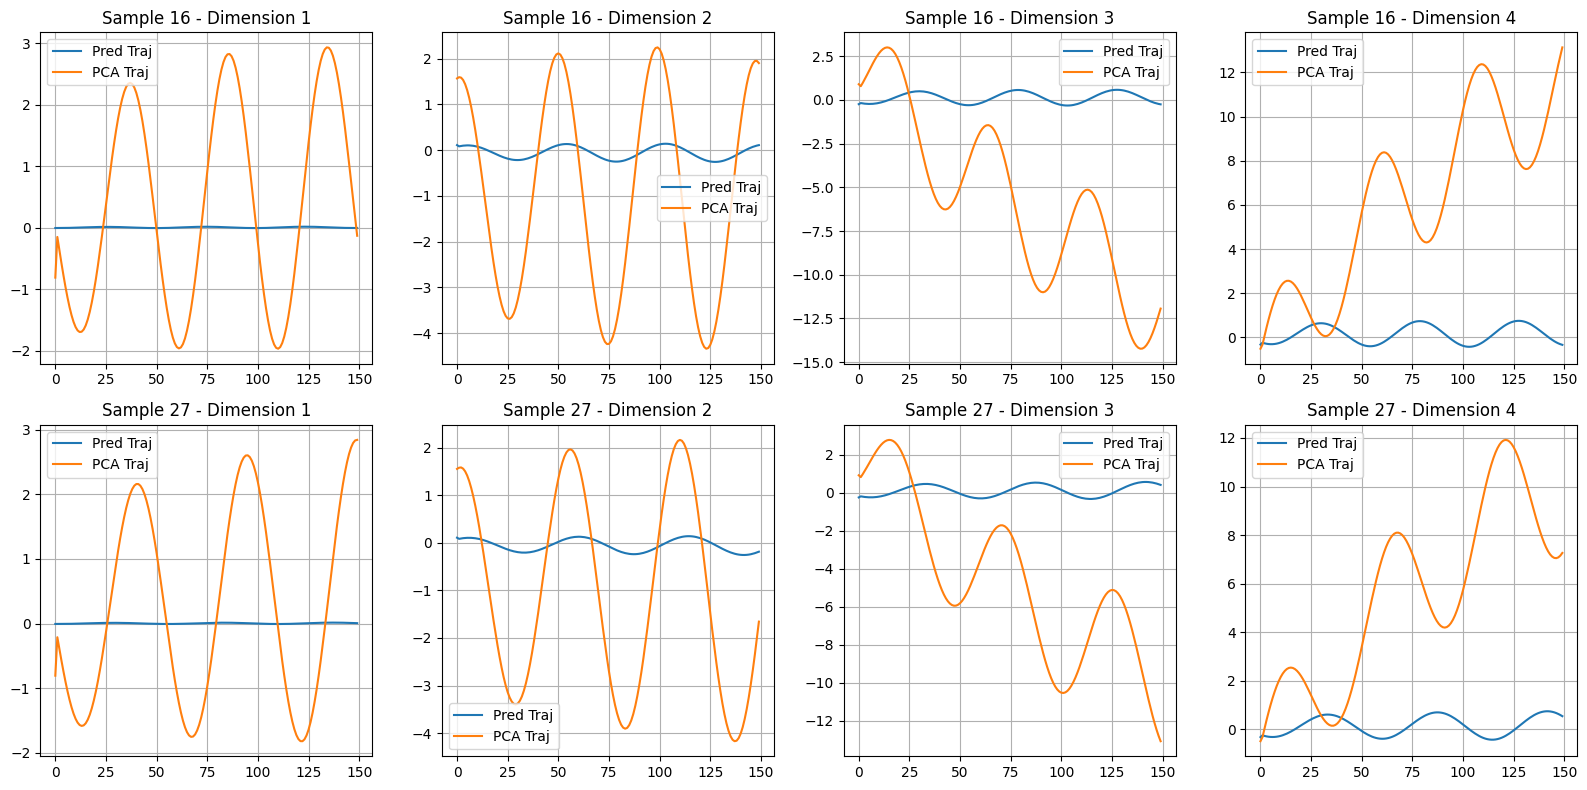

In [176]:
import numpy as np
import matplotlib.pyplot as plt

# 随机挑选10个样本的行索引
num_samples = 2
indices = np.random.choice(len(x_data_pca_traj_train), num_samples, replace=False)
print(indices)

# 创建4列10行的子图
fig, axs = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))

# 循环处理每一个随机选取的样本
for i, idx in enumerate(indices):
    # 获取x_data_pred_traj_train和x_data_pca_traj_train的第idx个样本
    pred_traj = x_data_pred_traj_train[idx]  # 第idx行的数据
    pca_traj = x_data_pca_traj_train[idx]    # 对应的PCA
    print(i)

    # 绘制该样本的不同维度
    for j in range(4):
        axs[i, j].plot(pred_traj[:,j], label='Pred Traj')
        axs[i, j].plot(pca_traj[:, j], label='PCA Traj')
        axs[i, j].set_title(f'Sample {idx} - Dimension {j+1}')
        axs[i, j].legend()
        axs[i, j].grid(True)

# 设置整体布局和展示
plt.tight_layout()
plt.show()


In [177]:
calculate_relative_error(x_data_pca_traj_train[4], x_data_pca_pred_traj_train[4])

0.9960872

[35 25 14 29  9  3 33 22 40 26]
0
1
2
3
4
5
6
7
8
9


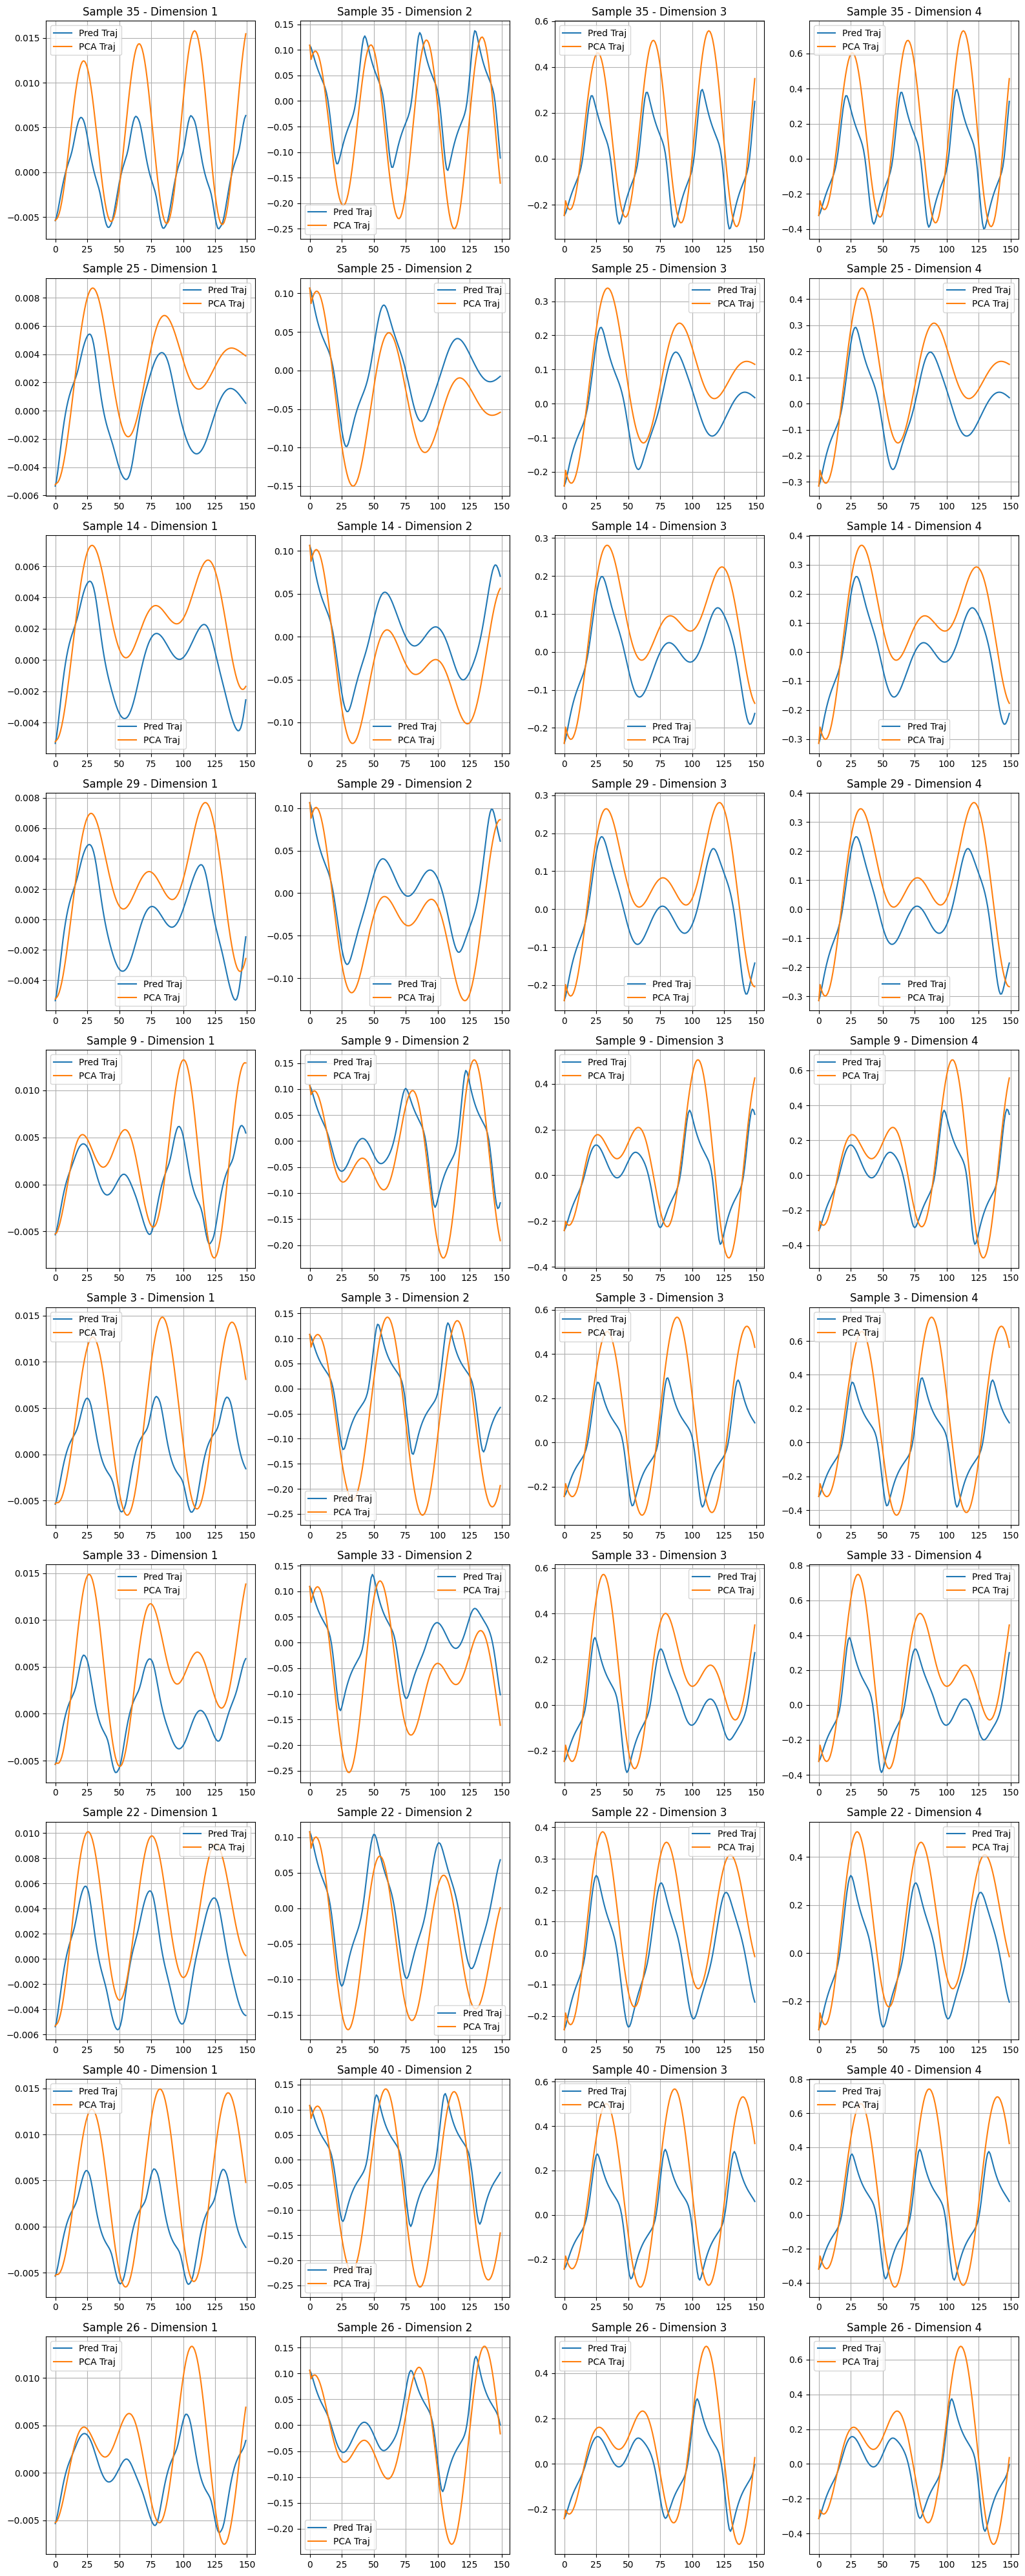

In [178]:
import numpy as np
import matplotlib.pyplot as plt

# 随机挑选10个样本的行索引
num_samples = 10
indices = np.random.choice(len(x_data_pca_traj_train), num_samples, replace=False)
print(indices)

# 创建4列10行的子图
fig, axs = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))

# 循环处理每一个随机选取的样本
for i, idx in enumerate(indices):
    # 获取x_data_pred_traj_train和x_data_pca_traj_train的第idx个样本
    pred_traj = x_dataset_train[idx]  # 第idx行的数据
    pca_traj = x_data_pred_traj_train[idx]    # 对应的PCA
    print(i)

    # 绘制该样本的不同维度
    for j in range(4):
        axs[i, j].plot(pred_traj[:,j], label='Pred Traj')
        axs[i, j].plot(pca_traj[:, j], label='PCA Traj')
        axs[i, j].set_title(f'Sample {idx} - Dimension {j+1}')
        axs[i, j].legend()
        axs[i, j].grid(True)

# 设置整体布局和展示
plt.tight_layout()
plt.show()
